## RNN LSTM Text Classificaiton model

### Dependencies and Libraries

In [1]:
import os
from collections import Counter
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir('drive/MyDrive/School Work/CS4248/News Labelling Project')

### Reading in data into pd dataframes, data viewing

In [2]:
# Read CSV file in
train_path = './raw_data/clean_fulltrain.csv'
test_path = './raw_data/clean_balancedtest.csv'
df = pd.read_csv(train_path, header=None)

print(type(df))

# Samples, number of columns, 0 = labels, column 1 = text
print('Total rows, Total Columns: ' + str(df.shape))
df.sample(5) # Random sample values to see

<class 'pandas.core.frame.DataFrame'>
Total rows, Total Columns: (48854, 2)


,0,1
19347,2,donald trump wants send mexico bill every sing...
36039,3,new narrative syria assads biological weaponsb...
41127,4,venezuelan baby girl died ah1n1 flu first deat...
17403,2,hercules actor called ferguson rioters outragi...
12483,1,new yorkit end era american entertainment mond...


In [3]:
# Get number of labels for each task
classes = ['Satire', 'Hoax', 'Propaganda', 'Reliable News']
label_numbers = [1,2,3,4]

for label in label_numbers:
    print(classes[label-1] + ': ' + str((df[0] == label).sum()))
print(df[0].value_counts())

Satire: 14047
Hoax: 6942
Propaganda: 17870
Reliable News: 9995
3    17870
1    14047
4     9995
2     6942
Name: 0, dtype: int64


### Reading in testing set

In [4]:
from sklearn.utils import shuffle
test_df = pd.read_csv(test_path, header=None)
# test_df = shuffle(test_df)

test_df

,0,1
0,1,many actors seem content churn performances qu...
1,1,football insiders calling unexpectedly severe ...
2,1,freak accident following game 3 nba finals cle...
3,1,north koreas official news agency announced to...
4,1,former alaska governor sarah palin would bring...
...,...,...
2995,4,air force mistakenly gave rival companies sens...
2996,4,united nations climate chief friday challenged...
2997,4,river plate midfielder diego buonanotte underg...
2998,4,lawmakers brink tuesday exempting nation 18000...


In [5]:
# Get number of labels for each task
classes = ['Satire', 'Hoax', 'Propaganda', 'Reliable News']
label_numbers = [1,2,3,4]

for label in label_numbers:
    print(classes[label-1] + ': ' + str((test_df[0] == label).sum()))
print(test_df[0].value_counts())

Satire: 750
Hoax: 750
Propaganda: 750
Reliable News: 750
1    750
2    750
3    750
4    750
Name: 0, dtype: int64


### Count number of unique words in the entire dataset

In [6]:
# Count number of unique words
def unique_word_counter(texts):
    count = Counter() # Dictionary type
    # Access an entire string
    for text in texts:
        # Split each string into individual words separated by whitespace
        for word in text.split():
            count[word] += 1
    return count

In [7]:
# Run counter
counts = unique_word_counter(df[1])
unique_words_count = len(counts)
print('Number of unique words: ' + str(unique_words_count))
print('Most Common Words:')
counts.most_common(10)

Number of unique words: 252019
Most Common Words:


[('said', 95152),
 ('us', 78350),
 ('one', 64372),
 ('would', 61931),
 ('people', 58751),
 ('government', 45594),
 ('like', 44459),
 ('new', 43537),
 ('time', 43174),
 ('also', 40434)]

### Prepare datasets, convert into numpy format for Keras Model

In [8]:
X_train = df[1].to_numpy()
y_train = df[0].to_numpy()

X_test = test_df[1].to_numpy()
y_test = test_df[0].to_numpy()

y_train = pd.get_dummies(df[0]).values
y_test = pd.get_dummies(test_df[0]).values
print(type(y_train))
print(type(y_test))

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(48854,) (3000,)
(48854, 4) (3000, 4)


In [9]:
y_train

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]], dtype=uint8)

In [10]:
y_test

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]], dtype=uint8)

### Tokenise words into numbers
- Each word will be assigned a specific number, according to how many unique words we have
- Inspired from this [Youtube Video](https://www.youtube.com/watch?v=kxeyoyrf2cM&ab_channel=PythonEngineer)

In [11]:
# Each string is turned into a sequence of integers
tokenizer = Tokenizer(num_words=unique_words_count)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

### Pad sequences to a common length

In [12]:
# Determine minimum number of words in a sequence 65218, 

padding_length = 1000

length_count = 0
for item in X_train:
    length = len(item)
    if length > padding_length:
        length_count += 1
print('Number of texts > word length: ' + str(length_count))

Number of texts > word length: 2122


In [13]:
X_train = pad_sequences(X_train, maxlen=padding_length, padding="post", truncating="post")
X_test = pad_sequences(X_test, maxlen=padding_length, padding="post", truncating="post")

# Ensure padded shape of dimension
X_train.shape, X_test.shape

((48854, 1000), (3000, 1000))

In [14]:
X_train.shape[1]

1000

### Load model for evaluation

In [15]:
from tensorflow.python.client import device_lib
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")
print(device_lib.list_local_devices())

No GPU found
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12939851774938877347
xla_global_id: -1
]


In [16]:
from keras.models import load_model
model = load_model('./TrainedModels/RNN_LSTM_Best.h5') # This is the better model

predictions = model.predict(X_test)

In [17]:
predictions

array([[9.1671222e-01, 5.2941535e-02, 9.1994647e-03, 2.1146744e-02],
       [9.6812463e-01, 1.6336598e-02, 1.8271473e-03, 1.3711619e-02],
       [9.3922877e-01, 7.9268022e-03, 4.0852218e-03, 4.8759166e-02],
       ...,
       [8.8393682e-01, 7.4064038e-03, 7.6173954e-03, 1.0103950e-01],
       [2.7800595e-02, 3.6155636e-04, 7.8231506e-03, 9.6401471e-01],
       [3.5140589e-02, 4.8526292e-04, 9.6007371e-03, 9.5477337e-01]],
      dtype=float32)

In [18]:
len(predictions)

3000

In [19]:
prediction_labels = []
for prediction in predictions:
    prediction_labels.append(np.argmax(prediction))
prediction_labels[0:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [20]:
actual_labels = []
for label in y_test:
    actual_labels.append(np.argmax(label))
actual_labels[0:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

def score_model(predictions, target_value):
    score = f1_score(target_value, predictions, average='macro')
    print('F1 score = {}'.format(score))
    accuracy = accuracy_score(target_value, predictions)
    print('Accuracy = {}'.format(accuracy))
    precision = precision_score(target_value, predictions, average='micro')
    print('Precision = {}'.format(precision))
    print()

    # Print confusion matrix
def print_confusion_matrix(predictions, true_labels):
    cm = confusion_matrix(true_labels, predictions)
    cm_plot = ConfusionMatrixDisplay(confusion_matrix = cm)
    cm_plot.plot()

classes = ['Satire', 'Hoax', 'Propaganda', 'Reliable News']

In [22]:
score_model(prediction_labels, actual_labels)

F1 score = 0.7041111076665647
Accuracy = 0.705
Precision = 0.705



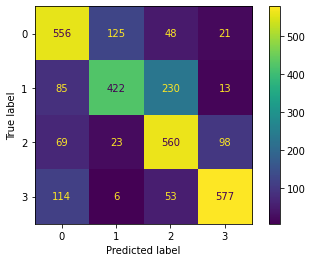

In [23]:
print_confusion_matrix(prediction_labels, actual_labels)

In [24]:
sequence_length = padding_length
vector_dimensions = 100
is_preprocessed_text = True

print('Sequence length: ' + str(sequence_length))
print('Embedding Vector Dimensions: ' + str(vector_dimensions))
print('Is clean text: ' + str(is_preprocessed_text))

Sequence length: 1000
Embedding Vector Dimensions: 100
Is clean text: True


In [25]:
output_df = pd.read_csv(test_path, header=None)

output_predictions = [] 
for label in prediction_labels:
    output_predictions.append(label + 1)

In [26]:
output_df[2] = output_predictions
output_df

,0,1,2
0,1,many actors seem content churn performances qu...,1
1,1,football insiders calling unexpectedly severe ...,1
2,1,freak accident following game 3 nba finals cle...,1
3,1,north koreas official news agency announced to...,1
4,1,former alaska governor sarah palin would bring...,1
...,...,...,...
2995,4,air force mistakenly gave rival companies sens...,4
2996,4,united nations climate chief friday challenged...,4
2997,4,river plate midfielder diego buonanotte underg...,1
2998,4,lawmakers brink tuesday exempting nation 18000...,4


In [29]:
score_model(output_df[2], output_df[0])

F1 score = 0.7041111076665647
Accuracy = 0.705
Precision = 0.705



In [30]:
# output_df.to_csv('LSTM_Base_Predictions.csv', header=False, index=False)